##🔹 Step 1: Install Dependencies

In [ ]:
# # Install required libraries (only needed in Colab)
# !pip install -q matplotlib opencv-python torch torchvision
import torch
import torch.nn as nn
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!wget -q -O dog.jpg https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg

##🔹 Step 2: Load Pre-trained Model (ResNet-18)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()  # Set to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##🔹 Step 3: Image Preprocessing

In [ ]:
def preprocess_image(img_path):
    img_np = cv2.imread(img_path)  # Use cv2.imread (or imageio if you prefer)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB) # Important: Convert BGR to RGB for PIL

    img_pil = Image.fromarray(img_np)  # Convert NumPy array to PIL Image

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img_pil).unsqueeze(0) # Apply transform to PIL image
    return img

##🔹 Step 4: CAM Implementation

In [ ]:
class CAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None

        # Register forward hook
        target_layer.register_forward_hook(self.save_activations)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def generate(self, input_tensor):
        # Forward pass through model
        output = self.model(input_tensor)

        # Get predicted class
        class_idx = torch.argmax(output).item()

        # Get weights from final fully connected layer
        weights = self.model.fc.weight[class_idx]

        # Create CAM by weighting activations
        cam = torch.einsum('chw,c->hw',
                          self.activations.squeeze(0),
                          weights)

        # Post-processing
        cam = nn.ReLU()(cam).detach().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        return cam, class_idx

##🔹 Step 5: Prepare Sample Image

In [ ]:
img_path = "dog.jpg"
input_tensor = preprocess_image(img_path)

##🔹 Step 6: Initialize CAM

In [ ]:
target_layer = model.layer4[-1].conv2  # Last convolutional layer
cam_generator = CAM(model, target_layer)

# Generate CAM
heatmap, class_idx = cam_generator.generate(input_tensor)

##🔹 Step 7: Visualization

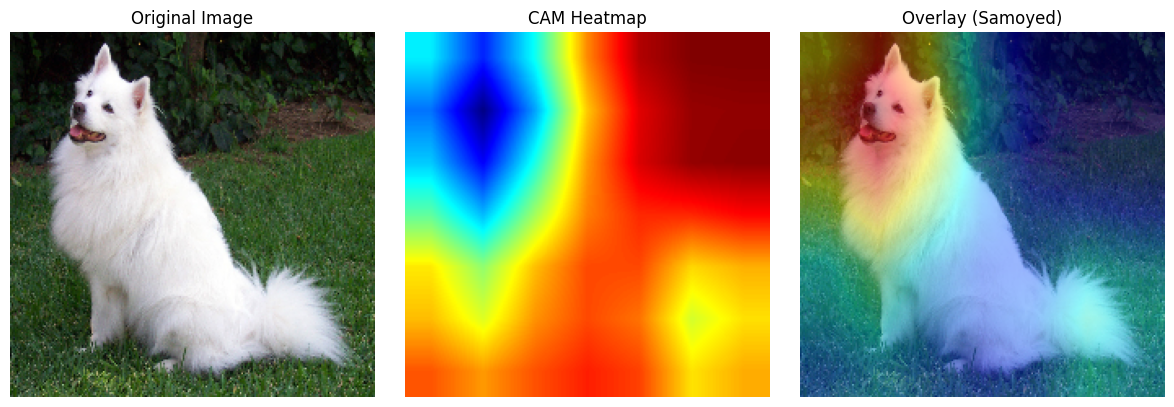

In [ ]:
def visualize_cam(img_path, heatmap, class_idx):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    # Create heatmap overlay
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Get class label
    labels = models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
    class_label = labels[class_idx]

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('CAM Heatmap')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Overlay ({class_label})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_cam(img_path, heatmap, class_idx)

##🔹 Attack Demo

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import glob
from PIL import Image
import argparse
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import random
from shutil import copy2
import torch.nn.functional as F
import torch.autograd as autograd

import cv2

from scipy.spatial.distance import cdist

import math
from torch.utils import model_zoo

from copy import deepcopy
import re
from collections import OrderedDict
from torch.autograd import Function


import cv2
from skimage import exposure
from skimage import filters
import matplotlib.pyplot as plt
import time
import torchvision.models as models

In [ ]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, out_keys=None):
        out = {}
        x = self.conv1(x)
        out["c1"] = x
        x = self.bn1(x)
        out["bn1"] = x
        x = self.relu(x)
        out["r1"] = x
        x = self.maxpool(x)
        out["p1"] = x

        x = self.layer1(x)
        out["l1"] = x
        x = self.layer2(x)
        out["l2"] = x
        x = self.layer3(x)
        out["l3"] = x
        x = self.layer4(x)
        out["l4"] = x

        x = self.avgpool(x)
        out["gvp"] = x
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out["fc"] = x

        if out_keys is None:
            return x

        res = {}
        for key in out_keys:
            res[key] = out[key]
        return res


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [ ]:
class CAM(object):
    """
    The CAM class generates Class Activation Maps (CAMs) from a given model.
    It uses intermediate outputs of the model (e.g., feature maps from a convolutional
    layer) and the weights of the final fully-connected layer to compute the CAM.
    """

    def __init__(self, model, output_keys=None):
        """
        Constructor for the CAM class.

        Parameters:
        - model: The neural network model (e.g., a ResNet) for which CAMs will be generated.
        - output_keys: Optional list of keys specifying which intermediate outputs
                       to extract from the model. If not provided, defaults to ["l4", "gvp", "fc"].
        """
        # Store the model.
        self.model = model

        # Move the model to the CUDA device.
        self.model.cuda()

        # Set the model to evaluation mode so that layers like dropout and batchnorm
        # behave accordingly (i.e., no random dropout, using running statistics).
        self.model.train(False)

        # If output_keys are provided, store them as a list; otherwise, use default keys.
        if output_keys is not None:
            self.output_keys = list(output_keys)
        else:
            self.output_keys = ["l4", "gvp", "fc"]

    def forward(self, x, out_keys=None):
        """
        Performs a forward pass through the model and returns specific intermediate outputs.

        Parameters:
        - x: The input tensor.
        - out_keys: Optional list of keys specifying which outputs to extract.
                    If not provided, the default keys in self.output_keys are used.

        Returns:
        - A list of outputs corresponding to the requested keys.
        """
        # Use default output keys if none are provided.
        if out_keys is None:
            out_keys = self.output_keys
        # Pass the input through the model. The model is expected to accept an 'out_keys'
        # parameter and return a dictionary containing the requested intermediate outputs.
        res = self.model(x, out_keys)
        # Extract and return the outputs corresponding to each key in out_keys.
        rets = [res[key] for key in out_keys]
        return rets

    def __call__(self, x, y=None, out_keys=None):
        """
        Enables the CAM instance to be called like a function.
        It computes the CAM for a given input.

        Parameters:
        - x: The input tensor.
        - y: (Optional) The target label. If not provided, the label is inferred by
             taking the argmax of the logits from the model.
        - out_keys: (Optional) Keys specifying which intermediate outputs to extract.

        Returns:
        - logits: The model's output logits.
        - prod: The computed Class Activation Map (CAM).
        """
        # If a target label is not provided, infer it from the model's prediction.
        if y is None:
            with torch.no_grad():
                # Run a forward pass to get the logits (ignoring intermediate outputs).
                _, _, logits = self.forward(x, out_keys=out_keys)
                # Move logits to CPU and convert to a numpy array.
                logits = logits.cpu().numpy()[0]
            # Determine the predicted label as the index of the maximum logit.
            true_label = int(np.argmax(logits))
            # Create a tensor containing the predicted label and move it to CUDA.
            y = torch.tensor([true_label]).cuda()

        # Run the forward pass to obtain the intermediate outputs:
        # l4: feature maps from a specific layer,
        # gvp: output from a global pooling layer,
        # logits: final output logits.
        l4, gvp, logits = self.forward(x)

        # Extract the weights from the model's final fully-connected (linear) layer for the target label.
        # Here, self.model.fc.weight[y] selects the weight vector corresponding to the label.
        # The view reshapes it to (1, number_of_channels, 1, 1) so it can be broadcasted with l4.
        wc = self.model.fc.weight[y].view(1, -1, 1, 1)

        # Compute the weighted product of the feature maps (l4) with the extracted weights.
        # The product is summed over the channel dimension to produce a spatial map (CAM).
        prod = (wc * l4).sum(1)

        # Return the logits and the computed CAM.
        return logits, prod


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# -----------------------------------------------------------------------------
# Helper: ImageNet normalization (for ResNet50)
# -----------------------------------------------------------------------------
def imagenet_normalize(x, mean=None, std=None):
    if mean is None:
        mean = [0.485, 0.456, 0.406]
    if std is None:
        std = [0.229, 0.224, 0.225]
    mu = torch.tensor(mean, device=x.device).view(1, 3, 1, 1)
    st = torch.tensor(std, device=x.device).view(1, 3, 1, 1)
    return (x - mu) / st

# -----------------------------------------------------------------------------
# to_mask: Normalize a CAM to the [0,1] range.
# -----------------------------------------------------------------------------
def to_mask(m):
    m = m - m.min()
    m /= m.max() + 1e-8
    return m

# -----------------------------------------------------------------------------
# make_cam: Create a color overlay from the heatmap and blend it with the image.
# -----------------------------------------------------------------------------
def make_cam(x, m):
    # Resize the heatmap to 224x224 and convert to uint8 for cv2.
    mask_x = cv2.applyColorMap(
        np.uint8(255. * cv2.resize(m, (224, 224))), cv2.COLORMAP_JET)
    # cv2 returns BGR; convert to RGB and reorder dimensions to (3, H, W)
    mask_x = mask_x[..., ::-1].transpose(2, 0, 1)
    mask_x = np.float32(mask_x / 255.)
    # Overlay the color mask on the original image.
    cam_x = x + mask_x
    cam_x = cam_x / (cam_x.max() + 1e-8)
    return cam_x

# -----------------------------------------------------------------------------
# generate_cam_from_image:
# Reads a single image from image_path, processes it, generates its CAM, and
# prepares a results dictionary.
# -----------------------------------------------------------------------------
def generate_cam_from_image(cam_model, image_path, device):
    # Read the image, convert to RGB, and resize to 224x224.
    image_pil = Image.open(image_path).convert('RGB')
    image_pil = image_pil.resize((224, 224))
    # Use torchvision.transforms to convert PIL image to a tensor.
    transform = transforms.ToTensor()  # produces a tensor in [0,1] with shape (3,224,224)
    image_tensor = transform(image_pil)

    # Add batch dimension and move to device.
    x = image_tensor.unsqueeze(0).to(device)  # shape: (1,3,224,224)

    # Get the model's prediction (using normalized input).
    model = cam_model.model
    with torch.no_grad():
        logits = model(imagenet_normalize(x))
    logits_np = logits.cpu().numpy()[0]
    pred_label = int(np.argmax(logits_np))

    # Compute the CAM (using the predicted label).
    label_tensor = torch.tensor(pred_label, device=device)
    with torch.no_grad():
        _, prod_x = cam_model(imagenet_normalize(x), label_tensor)
    mask_x = to_mask(prod_x.detach())

    # Prepare an overlay image of the CAM on the original image.
    x_np = x.detach().cpu().numpy()[0]  # shape: (3,224,224)
    mask_np = mask_x.detach().cpu().numpy()[0]  # shape: (7,7)
    cam_overlay = make_cam(x_np, mask_np)

    # Create a random target label different from the predicted label.
    target = np.random.randint(0, 1000)
    if target == pred_label:
        target = (target + 1) % 1000

    # Pack results in a dictionary.
    res = {}
    res['img_x'] = x.detach().cpu().numpy()          # (1, 3, 224, 224)
    res['img_y'] = [pred_label]                        # True label
    res['img_yt'] = [target]                           # Random target label
    res['logits_x'] = [logits_np]                      # Raw logits
    res['prod_x'] = prod_x.detach().cpu().numpy()[0]   # The raw CAM (e.g. (7,7))
    res['mask_x'] = mask_x[None].detach().cpu().numpy()  # Normalized CAM (1,7,7)
    res['cam_overlay'] = cam_overlay                   # Overlay image (3,224,224)
    return res

# -----------------------------------------------------------------------------
# main:
# Loads the model, creates the CAM generator, generates the CAM for dog.jpg,
# and saves the results to an NPZ file.
# -----------------------------------------------------------------------------
def main(image_path, save_path, device):
    # Load a pretrained ResNet50.
    model = resnet18(pretrained=True)
    model.eval()
    model.to(device)

    # Create a CAM generator.
    cam_model = CAM(model)

    # Generate the CAM and other outputs from the input image.
    res = generate_cam_from_image(cam_model, image_path, device)

    # Save the results.
    np.savez(save_path, **res)
    print("Saved CAM results to:", save_path)

# -----------------------------------------------------------------------------
# generate_benign_cam:
# Sets file paths and calls main().
# -----------------------------------------------------------------------------
def generate_benign_cam():
    image_path = 'dog.jpg'
    save_path = 'dog.npz'
    device = 'cuda'  # Change to 'cpu' if needed.
    main(image_path, save_path, device)

# -----------------------------------------------------------------------------
# Run the script.
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    generate_benign_cam()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 433MB/s]


Saved CAM results to: dog.npz


In [ ]:
# This function performs a forward pass through the model and returns specific intermediate outputs.
def cam_forward(model_tup, x):
    # Unpack the model and the preprocessing function from the provided tuple.
    # model_tup is expected to have at least two elements: (model, pre_fn, ...)
    model, pre_fn = model_tup[:2]

    # Preprocess the input x using the pre_fn and then pass it through the model.
    # The argument 'out_keys' tells the model to return a dictionary of intermediate outputs.
    # Here, we request three keys:
    #   - "l4": represents features from layer 4,
    #   - "gvp": represents the output after a global average pooling layer,
    #   - "fc": represents the final fully connected layer output (logits).
    res = model(pre_fn(x), out_keys=["l4", "gvp", "fc"])

    # Return the outputs corresponding to the keys "l4", "gvp", and "fc" as a tuple.
    return res['l4'], res['gvp'], res['fc']


# This function extracts the weight parameters from the model's final fully-connected (linear) layer.
def cam_fc_weight(model_tup):
    # Retrieve the model from the tuple.
    model = model_tup[0]
    # Return the weights of the model's linear layer.
    # (It is assumed that the model has an attribute 'linear' which is its final layer.)
    return model.linear.weight


# This function prepares and returns a model tuple and a tuple of functions related to CAM generation.
def cam_resnet():
    # Load a ResNet18 model pretrained on ImageNet.
    model = resnet18(pretrained=True)

    # Create a tuple that contains:
    #   - the model,
    #   - a preprocessing function (here, imagenet_normalize) that will normalize inputs according to ImageNet statistics,
    #   - the expected input size as a tuple (224, 224).
    model_tup = (model, imagenet_normalize, (224, 224))

    # Return a tuple where:
    #   - The first element is the model tuple (model_tup).
    #   - The second element is a tuple of two functions:
    #         * cam_forward: for performing a forward pass and extracting intermediate features.
    #         * cam_fc_weight: for extracting the weights from the model's fully-connected layer.
    return model_tup, (cam_forward, cam_fc_weight)


In [ ]:
# =============================================================================
# This function generates the logits and CAMs for a batch of images.
#
# Parameters:
# - model_tup: a tuple where the first element is the model and the second is a
#              preprocessing function.
# - forward_tup: (unused in this code) could be used for additional forward functions.
# - bx: a batch (list or tensor) of input images.
# - by: corresponding target labels for each image in bx.
# - device: string indicating the device (e.g., 'cuda' or 'cpu').
#
# Returns:
# - A tuple of two tensors: one containing the logits for each image,
#   and the other containing the corresponding CAMs.
# =============================================================================
def generate_cams(model_tup, forward_tup, bx, by, device):
    # Initialize empty lists to store logits and CAMs.
    logits, cams = [], []
    # Create an instance of the CAM generator using the provided model.
    cam_model = CAM(model_tup[0])
    # Loop over each image in the batch.
    for index, img in enumerate(bx):
        # Add a batch dimension (img[None]) and preprocess the image using model_tup[1].
        # Then compute the logit and CAM for this image given its target label.
        logit, prod_x = cam_model(model_tup[1](img[None]), by[index])
        # Remove extra dimensions from the logit and add it to the list.
        logits.append(logit.squeeze())
        # Append the generated CAM to the list.
        cams.append(prod_x)
    # Stack the list of logits and CAMs into batch tensors and return them.
    return torch.stack(logits, axis=0), torch.stack(cams, axis=0)

# =============================================================================
# This function performs the adversarial attack on a batch of images.
#
# Parameters:
# - config: a dictionary containing configuration parameters (learning rates,
#           number of iterations, epsilon, etc.).
# - model_tup: tuple containing the model and its preprocessing function.
# - forward_tup: (unused in this code) placeholder for additional forward functions.
# - batch_tup: a tuple (bx_np, by_np) where bx_np is a numpy array of images and
#              by_np is a numpy array of corresponding labels.
# - cam_benign: the benign (unperturbed) CAM obtained before the attack.
#
# Returns:
# - A dictionary (dobj) containing the adversarial images, perturbations, CAMs,
#   logits, and success flags.
# =============================================================================
def attack_batch(config, model_tup, forward_tup, batch_tup, cam_benign):
    # Unpack the model and preprocessing function from the tuple.
    model, pre_fn = model_tup[:2]
    # Determine if we are using GPU.
    cuda = config['device'] == 'gpu'
    # Unpack the batch data: bx_np (images) and by_np (labels).
    bx_np, by_np = batch_tup
    # Determine the number of images in the batch.
    batch_size = len(bx_np)
    # Convert the numpy arrays to PyTorch tensors.
    bx, by = torch.tensor(bx_np), torch.tensor(by_np)
    # Convert the benign CAM numpy array to a tensor.
    m0 = torch.tensor(cam_benign)
    # If GPU is to be used, move the tensors to CUDA.
    if cuda:
        bx, by, m0 = bx.cuda(), by.cuda(), m0.cuda()
    # Flatten the benign CAM for each image to a 1D tensor (for loss computation later).
    m0_flatten = m0.view(batch_size, -1)
    # Create a clone of the input images that will be modified (the adversarial examples)
    # and enable gradient computation on them.
    bx_adv = bx.clone().detach().requires_grad_()

    # Retrieve learning rates and epsilon (maximum allowed perturbation) from config.
    s1_lr = config['s1_lr']
    s2_lr = config['s2_lr']
    eps = config['epsilon']
    # Initialize an empty dictionary to store outputs.
    dobj = {}

    # -------------------------------------------------------------------------
    # Compute edge weights from the unperturbed images for gradient scaling.
    # -------------------------------------------------------------------------
    # Convert images to grayscale by averaging over channels (result shape: (batch, 1, H, W)).
    unpert_gray = bx.cpu().numpy().mean(axis=1, keepdims=True)
    # Create an empty array of the same shape as unpert_gray to store edge maps.
    edges = np.empty_like(unpert_gray)
    # Compute the Sobel edge for each grayscale image.
    for index, image in enumerate(unpert_gray):
        edges[index] = filters.sobel(image.squeeze(0))
    # Convert the edge maps back to a PyTorch tensor and move to GPU.
    weights = torch.tensor(edges).to('cuda')

    # -------------------------------------------------------------------------
    # Stage 1: Basic adversarial perturbation.
    # -------------------------------------------------------------------------
    for i in range(config['s1_iters']):
        # Compute the model logits for the current adversarial images.
        logits = model(pre_fn(bx_adv))
        # Compute the negative log likelihood loss for the true labels.
        loss = F.nll_loss(logits, by, reduction='sum')
        # Compute gradients of the loss with respect to the adversarial images.
        loss_grad = autograd.grad([loss], [bx_adv])[0]

        # Optionally, print progress every 100 iterations.
        if i % 100 == 0:
            with torch.no_grad():
                # Compute average loss and count how many predictions are correct.
                loss_adv_mu = loss.item() / batch_size
                pred = torch.argmax(logits, 1)
                num_succeed = torch.sum(by == pred).item()
            # Uncomment the next line to print progress.
            # print('s1-step: %d, loss adv: %.2f, succeed: %d' % (i, loss_adv_mu, num_succeed))

        # Update the adversarial images.
        with torch.no_grad():
            # Multiply the sign of the gradient by the edge weights.
            loss_grad_sign = weights * loss_grad.sign()
            # Move the adversarial images in the negative gradient direction.
            bx_adv.data.add_(-s1_lr, loss_grad_sign)
            # Compute the difference (perturbation) from the original images.
            diff = bx_adv - bx
            # Clamp the perturbation so that it stays within the allowed epsilon.
            diff.clamp_(-eps, eps)
            # Update the adversarial images to be the original images plus the clamped perturbation.
            bx_adv.data = diff + bx
            # Ensure pixel values remain within the valid range [0, 1].
            bx_adv.data.clamp_(0, 1)

    # -------------------------------------------------------------------------
    # Stage 2: CAM-guided attack.
    # -------------------------------------------------------------------------
    # Set up the cost parameter for the CAM loss.
    c_begin, c_final = config['c'], config['c'] * 2
    # Calculate the increment for the cost parameter per iteration.
    c_inc = (c_final - c_begin) / config['s2_iters']
    c_now = config['c']

    # Create an array of indices corresponding to each image in the batch.
    label_indices = np.arange(0, batch_size, dtype=np.int64)

    # Iterate for the number of stage 2 iterations.
    for i in range(config['s2_iters']):
        # Compute a base confidence value that increases gradually.
        conf_base = 0.95 + i / config['s2_iters'] * 0.04
        # Generate random confidence values for each image in the batch.
        conf = np.random.uniform(conf_base, 1, size=(batch_size,)).astype(np.float32)
        # Create a confidence matrix for all classes (assuming 1000 classes).
        conf_mat = ((1 - conf) / 9.).reshape((batch_size, 1)).repeat(1000, 1)
        # Set the confidence for the true labels to the random confidence.
        conf_mat[label_indices, by_np] = conf

        # Convert the confidence matrix to a tensor and move it to GPU.
        by_one = torch.tensor(conf_mat, device='cuda')

        # Increase the cost parameter for the CAM loss.
        c_now += c_inc
        # Generate logits and CAM for the current adversarial images.
        logits, cam = generate_cams(model_tup, forward_tup, bx_adv, by, 'cuda')
        # Compute the adversarial loss using the negative log likelihood with a confidence weight.
        loss_adv = (-by_one * F.log_softmax(logits)).sum()
        # Flatten the CAM for each image.
        cam_flatten = cam.view(batch_size, -1)
        # Normalize the CAM: subtract the minimum and divide by the maximum.
        cam_flatten = cam_flatten - cam_flatten.min(1, True)[0]
        cam_flatten = cam_flatten / cam_flatten.max(1, True)[0]
        # Compute the difference between the current CAM and the benign (original) CAM.
        diff = cam_flatten - m0_flatten
        # Compute the CAM loss as the mean squared difference.
        loss_cam = torch.sum((diff * diff).mean(1))
        # Combine the adversarial loss and the weighted CAM loss.
        loss = torch.add(loss_adv, c_now, loss_cam)
        # Compute gradients of the total loss with respect to the adversarial images.
        loss_grad = autograd.grad([loss], [bx_adv])[0]

        # Optionally, print progress every 100 iterations.
        if i % 100 == 0:
            with torch.no_grad():
                pred = torch.argmax(logits, 1)
                loss_cam_mu = loss_cam.item() / batch_size
                loss_adv_mu = loss_adv.item() / batch_size
                num_succeed = torch.sum(by == pred).item()
                # The following lines update loss_adv and loss_cam for printing (if needed).
                loss_adv = loss_adv_mu
                loss_cam = loss_cam_mu
            # Uncomment the next line to print progress.
            # print('s2-step: %d, loss adv: %.2f, loss cam: %.5f, succeed: %d' % (i, loss_adv, loss_cam, num_succeed))

        # Update the adversarial images based on the CAM-guided loss.
        with torch.no_grad():
            loss_grad_sign = loss_grad.sign()
            bx_adv.data.add_(-s2_lr, loss_grad_sign)
            diff = bx_adv - bx
            diff.clamp_(-eps, eps)
            bx_adv.data = diff + bx
            bx_adv.data.clamp_(0, 1)
        # Free the gradient to save memory.
        del loss_grad

    # -------------------------------------------------------------------------
    # After the iterations, compute the final logits and normalized CAM.
    # -------------------------------------------------------------------------
    logits, cam = generate_cams(model_tup, forward_tup, bx_adv, by, 'cuda')
    cam_flatten = cam.view(batch_size, -1)
    cam_flatten = cam_flatten - cam_flatten.min(1, True)[0]
    cam_flatten = cam_flatten / cam_flatten.max(1, True)[0]

    # Store results in the dictionary:
    # - adv_x: the final adversarial images.
    # - pert: the perturbation added to the original images.
    # - adv_cam: the normalized adversarial CAMs, reshaped to (batch, 1, 7, 7).
    # - adv_logits: the logits for the adversarial images.
    # - adv_succeed: a flag indicating if the attack was successful.
    # - tcam: the benign CAMs.
    dobj['adv_x'] = bx_adv.detach().cpu().numpy()
    dobj['pert'] = (bx_adv - bx).detach().cpu().numpy()
    dobj['adv_cam'] = cam_flatten.detach().cpu().numpy().reshape((batch_size, 1, 7, 7))
    dobj['adv_logits'] = logits.detach().cpu().numpy()
    dobj['adv_succeed'] = (torch.argmax(logits, 1) == by).detach().cpu().numpy().astype(np.int64)
    dobj['tcam'] = cam_benign

    # Return the dictionary containing all adversarial attack results.
    return dobj

# =============================================================================
# This function freezes (disables gradients for) all parameters in the model.
# =============================================================================
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad_(False)

# =============================================================================
# The main attack function that loads the data, runs the attack on all batches,
# and saves the results in an NPZ file.
# =============================================================================
def attack(config):
    # Retrieve the CAM-enabled model and any additional forward functions.
    model_tup, forward_tup = cam_resnet()
    # Set the model to evaluation mode.
    model_tup[0].train(False)
    # Move the model to GPU if specified.
    if config['device'] == 'gpu':
        model_tup[0].cuda()
    # Freeze the model parameters.
    freeze_model(model_tup[0])

    # Load the dataset from an NPZ file.
    data_arx = np.load(config['data_path'])
    img_x, img_yt = data_arx['img_x'], data_arx['img_yt']
    cam_target = data_arx['mask_x']

    # Determine the number of images and the batch size.
    n, batch_size = len(img_x), config['batch_size']
    # Calculate the number of batches.
    num_batches = (n + batch_size - 1) // batch_size
    save_dobjs = []

    # Record the start time.
    start_time = time.time()

    # Process each batch one by one.
    for i in range(num_batches):
        si = i * batch_size
        ei = min(si + batch_size, n)
        # Slice out the images, labels, and benign CAMs for this batch.
        bx, byt, bm0 = img_x[si:ei], img_yt[si:ei], cam_target[si:ei]
        # Run the adversarial attack on this batch.
        dobj = attack_batch(config, model_tup, forward_tup, (bx, byt), bm0)
        # Append the results.
        save_dobjs.append(dobj)

    # Calculate the total elapsed time.
    estimated_time = time.time() - start_time

    # Concatenate results from all batches.
    keys = list(save_dobjs[0].keys())
    save_dobj = {}
    for key in keys:
        save_dobj[key] = np.concatenate([i[key] for i in save_dobjs], axis=0)

    # Save the elapsed time and original labels.
    save_dobj['time'] = estimated_time
    save_dobj['img_y'] = data_arx['img_y']
    save_dobj['logits_x'] = data_arx['logits_x']
    # Save the final results into an NPZ file.
    np.savez(config['save_path'], **save_dobj)

# =============================================================================
# This function sets up configuration parameters and starts the attack process.
# =============================================================================
def attack_cam():
    config = {}
    config['data_path'] = 'dog.npz'              # Path to the input NPZ file.
    config['save_path'] = 'cam_attack_output.npz'  # Where to save the attack results.
    config['device'] = 'gpu'                     # Device to use ('gpu' or 'cpu').
    config['batch_size'] = 10                    # Batch size for processing.
    config['epsilon'] = 0.031                    # Maximum perturbation.
    config['s1_iters'] = 300                     # Iterations for stage 1.
    config['s1_lr'] = 1./255                     # Learning rate for stage 1.
    config['s2_iters'] = 500                     # Iterations for stage 2.
    config['s2_lr'] = 1./255                     # Learning rate for stage 2.
    config['c'] = 5.                            # Initial cost parameter for CAM loss.

    # Start the attack process.
    attack(config)

In [ ]:
attack_cam()

<ipython-input-14-2c7c9713b8b2>:117: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  bx_adv.data.add_(-s1_lr, loss_grad_sign)
<ipython-input-14-2c7c9713b8b2>:158: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss_adv = (-by_one * F.log_softmax(logits)).sum()


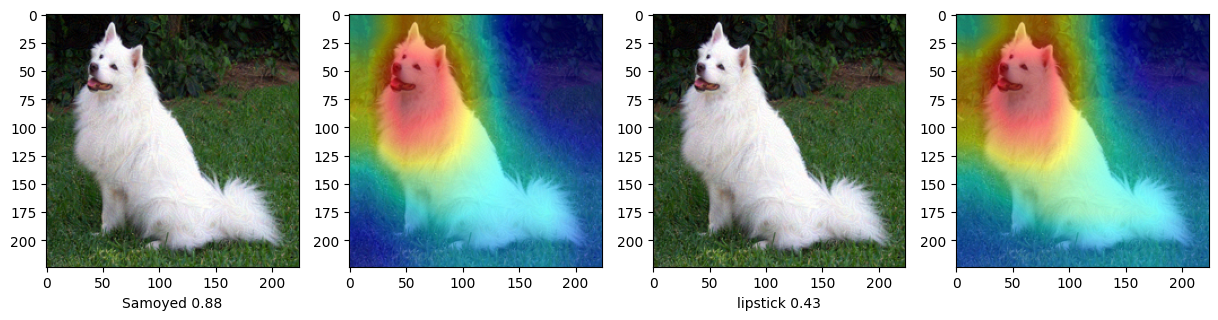

In [ ]:
# -----------------------------------------------------------------------------
# Resize an image.
# This function assumes the input image is in (C, H, W) format with pixel values in [0, 1].
# It converts the image to (H, W, C), scales to [0, 255], resizes it using OpenCV,
# then converts it back to (C, H, W) with pixel values in [0, 1].
# -----------------------------------------------------------------------------
def resize(img, new_size=(224, 224)):
    # Convert image from (C, H, W) to (H, W, C) and scale pixel values to [0, 255] as uint8.
    img = np.uint8(255 * img.transpose([1, 2, 0]))
    # Resize the image to the specified new size using linear interpolation.
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)
    # Transpose the image back to (C, H, W).
    img = img.transpose([2, 0, 1])
    # Convert image back to float32 in the range [0, 1] and return it.
    return np.float32(img / 255.)

# -----------------------------------------------------------------------------
# Overlay a heatmap onto an image.
# This function takes an image and a corresponding heatmap, resizes and color-maps the heatmap,
# and then overlays it on the original image.
# -----------------------------------------------------------------------------
def plot(img, heatmap):
    # Resize the heatmap to 224x224 and scale to [0, 255] as uint8.
    m1 = np.uint8(255 * cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_LINEAR))
    # Apply the JET colormap to the resized heatmap.
    m1 = cv2.applyColorMap(m1, cv2.COLORMAP_JET)
    # Convert the colormap output to float32 in the range [0, 1],
    # transpose from (H, W, C) to (C, H, W), and reverse the channel order (BGR -> RGB).
    m1 = np.float32(m1 / 255.).transpose([2, 0, 1])[::-1]
    # Overlay the color heatmap onto the original image.
    m1 = (img + m1)
    # Normalize the resulting image so that its maximum value is 1.
    m1 = m1 / m1.max()
    # Transpose back to (H, W, C) for visualization and return.
    return np.float32(m1).transpose((1, 2, 0))

# -----------------------------------------------------------------------------
# Load the adversarial attack output from an NPZ file and visualize the results.
# -----------------------------------------------------------------------------

# Load the NPZ file containing attack outputs.
attack_output = np.load('cam_attack_output.npz')

# Retrieve the list of class labels from the ResNet18 ImageNet weights metadata.
labels = models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]

# Convert benign logits (from the attack output) to a PyTorch tensor and apply softmax to get probabilities.
ben_prob = F.softmax(torch.from_numpy(attack_output['logits_x']), dim=1)
# Compute the maximum probability (confidence) for the benign example.
ben_conf, _ = torch.max(ben_prob, dim=1)

# Convert adversarial logits to a tensor and compute softmax probabilities.
adv_prob = F.softmax(torch.from_numpy(attack_output['adv_logits']), dim=1)
# Compute the maximum probability (confidence) for the adversarial example.
adv_conf, _ = torch.max(adv_prob, dim=1)
# Determine the predicted class index for the adversarial example.
class_index = np.argmax(adv_prob).item()

# Determine how many adversarial images are in the attack output.
length = len(attack_output['adv_x'])
# Create a matplotlib figure with a grid of subplots:
# 'length' rows and 4 columns, with a specified figure size.
f, axarr = plt.subplots(length, 4, figsize=(15, 25))
# Adjust the spacing between subplots.
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.2)

# -----------------------------------------------------------------------------
# Display the benign image with its true label and confidence.
# -----------------------------------------------------------------------------
# Set the xlabel for the first subplot using the true label and confidence.
axarr[0].set_xlabel(labels[attack_output['img_y'].item()] + f' {ben_conf.item():.2f}')
# Display the benign image. Transpose from (C, H, W) to (H, W, C) for matplotlib.
axarr[0].imshow(attack_output['adv_x'][0].transpose((1, 2, 0)))

# -----------------------------------------------------------------------------
# Display the benign CAM (overlay) on the image.
# -----------------------------------------------------------------------------
axarr[1].imshow(plot(attack_output['adv_x'][0], attack_output['tcam'].squeeze()))

# -----------------------------------------------------------------------------
# Display the adversarial image with its predicted label and confidence.
# -----------------------------------------------------------------------------
# Set the xlabel for the third subplot using the adversarial predicted label and confidence.
axarr[2].set_xlabel(labels[class_index] + f' {adv_conf.item():.2f}')
# Display the adversarial image (again, transposing for correct visualization).
axarr[2].imshow(attack_output['adv_x'][0].transpose((1, 2, 0)))

# -----------------------------------------------------------------------------
# Display the adversarial CAM (overlay) on the image.
# -----------------------------------------------------------------------------
axarr[3].imshow(plot(attack_output['adv_x'][0], attack_output['adv_cam'].squeeze()))


## Example output

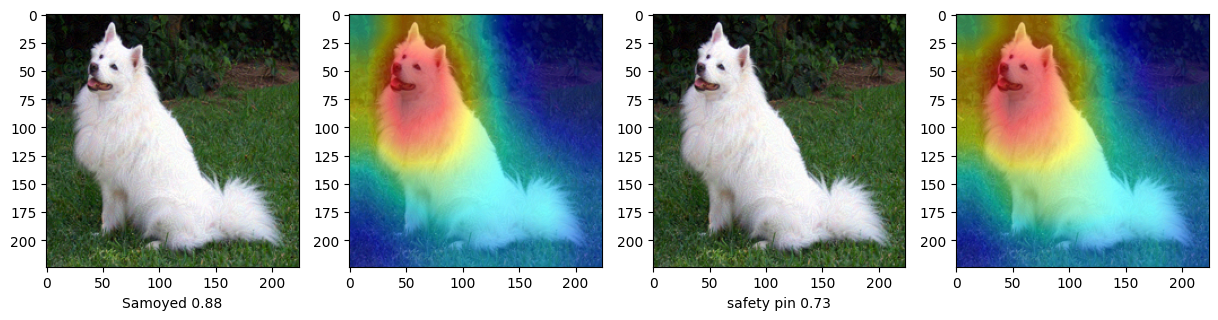